# Step 1) Data Preparation

In [9]:
import pandas as pd

df = pd.read_csv("../1_Data/INTC.csv",infer_datetime_format=True, parse_dates=['dt'], index_col=['dt'])

trainCount=int(len(df)*0.3)
dfTrain = df.iloc[:trainCount]

dfTest = df.iloc[trainCount:]
dfTest.to_csv('local_test/test_dir/input/data/training/data.csv')
dfTest.head()

,open,low,high,close,vol
dt,,,,,
2014-02-11,24.35,24.52,24.33,24.47,17947958.0
2014-02-12,24.51,24.69,24.37,24.55,25925263.0
2014-02-13,24.43,24.74,24.31,24.70,22940043.0
2014-02-14,24.58,24.76,24.41,24.76,20592672.0
2014-02-15,24.58,24.76,24.41,24.76,20592672.0


<IPython.core.display.Javascript object>


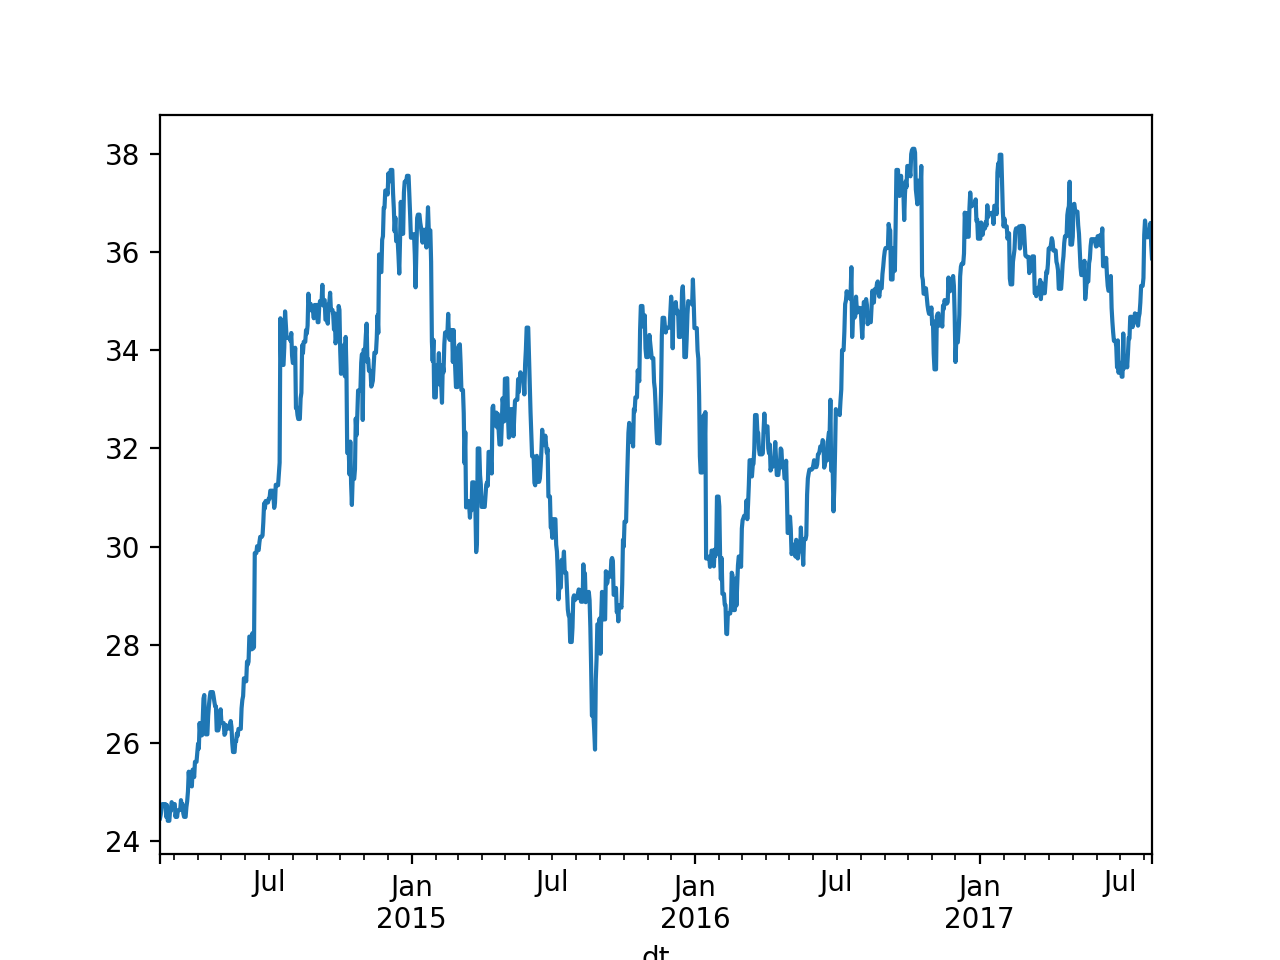

In [10]:
%matplotlib notebook
dfTest["close"].plot()

# Step 2) Modify Strategy Configuration 

In the following cell, you can adjust the parameters for the strategy.

* `user` = Name for Leaderboard (optional)
* `submitUrl` = Url for submitting to the Leaderboard (provided during workshop) (optional)
* `profit_target_pct` = Profit Target in Percent
* `stop_target_pct` = Stop Price in Percent
* `go_long` = Go Long for Breakout (true or false)
* `go_short` = Go Short for Breakout (true or false)
* `period` = Length of window for previous high and low
* `size` = The number of shares for a transaction

`Tip`: A good starting point for improving the strategy is to modify the profit / stop target and the risk/reward ratio. Equity Markets tend to have a long bias and only consider long trades could improve the performance.

In [12]:
%%writefile model/algo_config
{ "user" : "user",
  "submitUrl" : "",
  "profit_target_pct" : 1.0,
  "stop_target_pct" : 0.5,
  "go_long" : true,
  "go_short" : true,
  "period" : 9,
  "size" : 1000
}

Overwriting model/algo_config


In [13]:
%run update_config.py daily_breakout

config={"user": "user", "submitUrl": "", "profit_target_pct": 1.0, "stop_target_pct": 0.5, "go_long": true, "go_short": true, "period": 9, "size": 1000, "user_account": "user@547919252256", "algo_name": "daily_breakout"}


# Step 3) Modify Strategy Code

`Tip`: A good starting point for improving the strategy is to add additional indicators like ATR (Average True Range) before placing a trade. You want to avoid false signals if there is not enough volatility.

Here are some helpful links:
* Backtrader Documentation: https://www.backtrader.com/docu/strategy/
* TA-Lib Indicator Reference: https://www.backtrader.com/docu/talibindautoref/
* Backtrader Indicator Reference: https://www.backtrader.com/docu/indautoref/

In [14]:
%%writefile model/algo_daily_breakout.py
import backtrader as bt
from algo_base import *
import pytz
from pytz import timezone

class MyStrategy(StrategyTemplate):

    def __init__(self):  # Initiation
        super(MyStrategy, self).__init__()
        self.highest = bt.ind.Highest(period=self.config["period"])
        self.lowest = bt.ind.Lowest(period=self.config["period"])
        self.size = self.config["size"]

    def next(self):  # Processing
        super(MyStrategy, self).next()
        dt=self.datas[0].datetime.datetime(0)
        if not self.position:
            if self.config["go_long"] and self.datas[0] > self.highest[-1]:
                self.buy(size=self.size) # Go long
            elif self.config["go_short"] and self.datas[0] < self.lowest[-1]:
                self.sell(size=self.size) # Go short
        elif self.position.size>0 and self.datas[0] < self.highest[-1]:
            self.close()
        elif self.position.size<0 and self.datas[0] > self.lowest[-1]:          
            self.close()

Overwriting model/algo_daily_breakout.py


# Step 4) Backtest Locally (without submitting performance)

**Please note that the initial docker image build may take up to 5 min. Subsequent runs are fast.**

In [15]:
#Build Local Algo Image
!docker build -t algo_$(cat model/algo_name) .
!docker run -v $(pwd)/local_test/test_dir:/opt/ml --rm algo_$(cat model/algo_name) train

Sending build context to Docker daemon  994.8kB
Step 1/21 : FROM tensorflow/tensorflow:2.1.0rc2-py3
 ---> 021062082fec
Step 2/21 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python3          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> c02555b882c8
Step 3/21 : RUN wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz && tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib/ && ./configure --prefix=/usr && make && make install && cd ../ && rm -rf ta-lib && rm ta-lib-0.4.0-src.tar.gz
 ---> Using cache
 ---> 56af7d95ce5f
Step 4/21 : RUN wget https://bootstrap.pypa.io/get-pip.py && python get-pip.py
 ---> Using cache
 ---> d57b90d2f40b
Step 5/21 : RUN pip install numpy
 ---> Using cache
 ---> 67db982b9f66
Step 6/21 : RUN pip install scipy
 ---> Using cache
 ---> 32abf53b2022
Step 7/21 : RUN pip install scikit-learn
 ---> Using cache
 ---> c1c7dd639800
Step 8/21 : RUN pip i

[2015-01-10 00:00:00] BUY EXECUTED, Price: 36.77, PNL: 0.00, Cash: 105940.00
[2015-01-13 00:00:00] SELL EXECUTED, Price: 36.87, PNL: 100.00, Cash: 106050.00
[2015-01-21 00:00:00] SELL EXECUTED, Price: 35.85, PNL: 0.00, Cash: 105420.00
[2015-01-22 00:00:00] BUY EXECUTED, Price: 36.56, PNL: -710.00, Cash: 105340.00
[2015-01-23 00:00:00] BUY EXECUTED, Price: 36.96, PNL: 0.00, Cash: 104820.00
[2015-01-24 00:00:00] SELL EXECUTED, Price: 36.96, PNL: 0.00, Cash: 105340.00
[2015-01-27 00:00:00] SELL EXECUTED, Price: 34.40, PNL: 0.00, Cash: 105560.00
[2015-01-30 00:00:00] BUY EXECUTED, Price: 33.70, PNL: 700.00, Cash: 106040.00
[2015-01-31 00:00:00] SELL EXECUTED, Price: 33.70, PNL: 0.00, Cash: 106700.00
[2015-02-01 00:00:00] SOM:chg=80.00,cash=106700.00
[2015-02-03 00:00:00] BUY EXECUTED, Price: 33.78, PNL: -80.00, Cash: 105960.00
[2015-02-10 00:00:00] SELL EXECUTED, Price: 33.20, PNL: 0.00, Cash: 105460.00
[2015-02-11 00:00:00] BUY EXECUTED, Price: 33.67, PNL: -470.00, Cash: 105490.00
[2015-0

[2016-04-27 00:00:00] BUY EXECUTED, Price: 31.25, PNL: 140.00, Cash: 117660.00
[2016-04-29 00:00:00] SELL EXECUTED, Price: 30.86, PNL: 0.00, Cash: 118240.00
[2016-05-01 00:00:00] SOM:chg=820.00,cash=118240.00
[2016-05-03 00:00:00] BUY EXECUTED, Price: 30.41, PNL: 450.00, Cash: 118110.00
[2016-05-05 00:00:00] SELL EXECUTED, Price: 29.87, PNL: 0.00, Cash: 118080.00
[2016-05-06 00:00:00] BUY EXECUTED, Price: 29.61, PNL: 260.00, Cash: 118370.00
[2016-05-10 00:00:00] SELL EXECUTED, Price: 30.00, PNL: 0.00, Cash: 118230.00
[2016-05-11 00:00:00] BUY EXECUTED, Price: 30.16, PNL: -160.00, Cash: 118210.00
[2016-05-13 00:00:00] SELL EXECUTED, Price: 29.86, PNL: 0.00, Cash: 118160.00
[2016-05-14 00:00:00] BUY EXECUTED, Price: 29.86, PNL: 0.00, Cash: 118210.00
[2016-05-17 00:00:00] BUY EXECUTED, Price: 30.57, PNL: 0.00, Cash: 117620.00
[2016-05-18 00:00:00] SELL EXECUTED, Price: 30.03, PNL: -540.00, Cash: 117670.00
[2016-05-20 00:00:00] SELL EXECUTED, Price: 29.73, PNL: 0.00, Cash: 117250.00
[2016-

[2017-04-11 00:00:00] SELL EXECUTED, Price: 35.77, PNL: 0.00, Cash: 121000.00
[2017-04-18 00:00:00] BUY EXECUTED, Price: 35.43, PNL: 340.00, Cash: 121310.00
[2017-04-20 00:00:00] BUY EXECUTED, Price: 36.18, PNL: 0.00, Cash: 121310.00
[2017-04-29 00:00:00] SELL EXECUTED, Price: 36.10, PNL: -80.00, Cash: 121230.00
[2017-05-01 00:00:00] SOM:chg=320.00,cash=121230.00
[2017-05-11 00:00:00] SELL EXECUTED, Price: 35.91, PNL: 0.00, Cash: 121450.00
[2017-05-16 00:00:00] BUY EXECUTED, Price: 35.75, PNL: 160.00, Cash: 121390.00
[2017-05-18 00:00:00] SELL EXECUTED, Price: 35.19, PNL: 0.00, Cash: 121360.00
[2017-05-19 00:00:00] BUY EXECUTED, Price: 35.15, PNL: 40.00, Cash: 121430.00
[2017-05-24 00:00:00] BUY EXECUTED, Price: 35.98, PNL: 0.00, Cash: 121570.00
[2017-05-31 00:00:00] SELL EXECUTED, Price: 36.31, PNL: 330.00, Cash: 121760.00
[2017-06-01 00:00:00] SOM:chg=530.00,cash=121760.00
[2017-06-03 00:00:00] BUY EXECUTED, Price: 36.27, PNL: 0.00, Cash: 121810.00
[2017-06-07 00:00:00] SELL EXECUTED

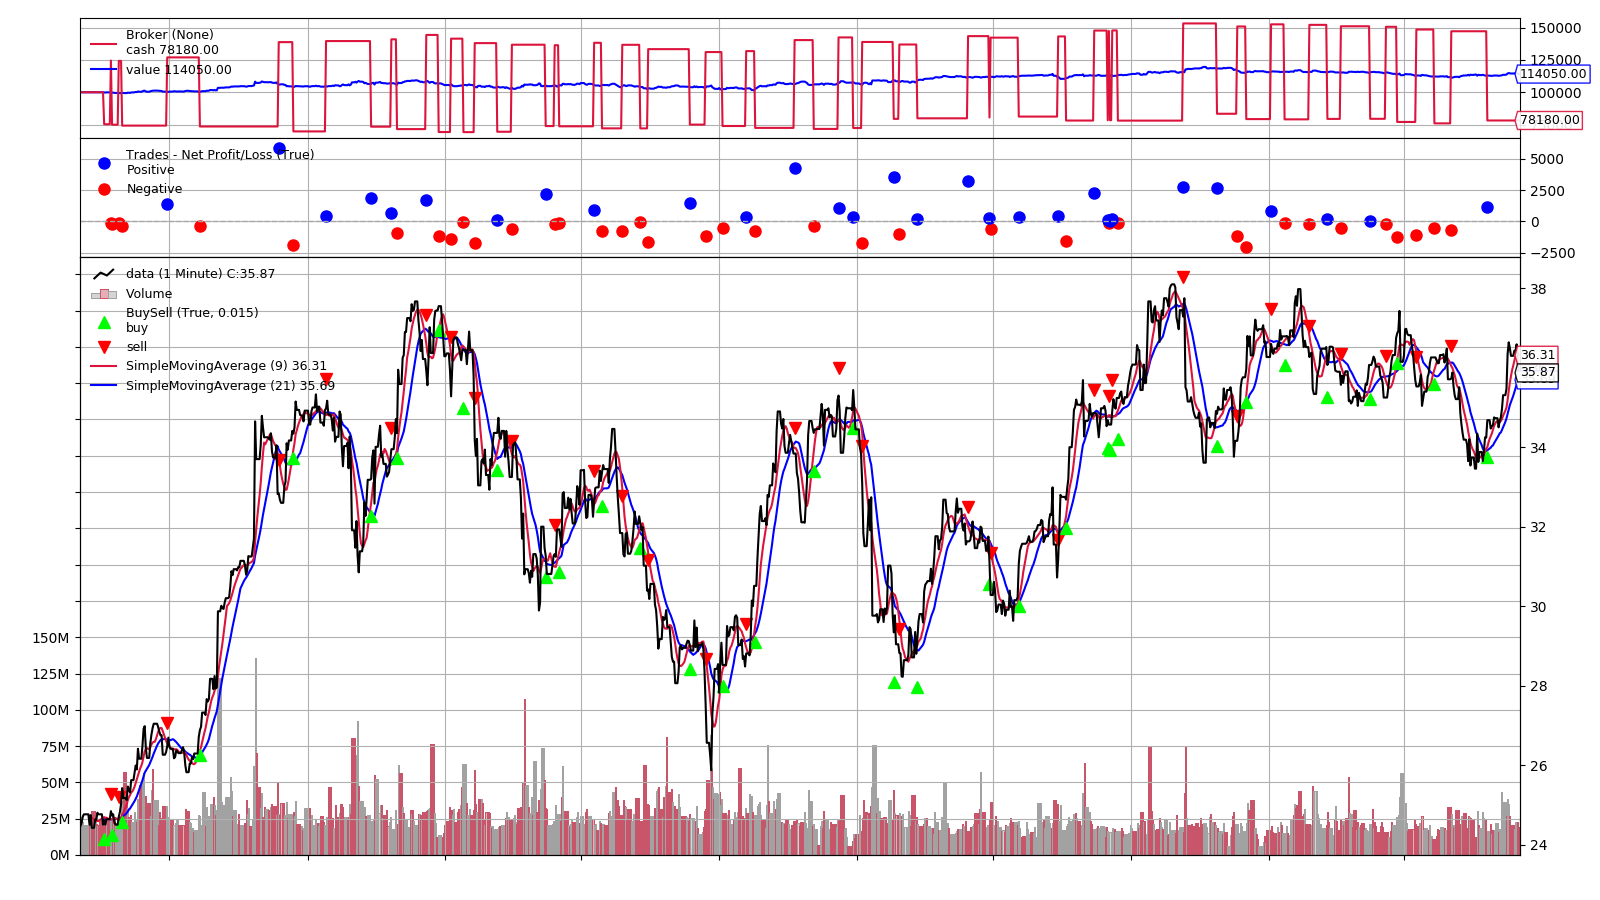

In [16]:
from IPython.display import Image
Image(filename='local_test/test_dir/model/chart.png')

## Refine your trading strategy (step 2 to 4). Once you are ready to submit the performance of your strategy, move on to the next step.

# Step 5) Run Backtest on SageMaker and submit performance

In [17]:
#Deploy Algo Image to ECS
!./build_and_push.sh

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  1.134MB
Step 1/21 : FROM tensorflow/tensorflow:2.1.0rc2-py3
 ---> 021062082fec
Step 2/21 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python3          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> c02555b882c8
Step 3/21 : RUN wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz && tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib/ && ./configure --prefix=/usr && make && make install && cd ../ && rm -rf ta-lib && rm ta-lib-0.4.0-src.tar.gz
 ---> Using cache
 ---> 56af7d95ce5f
Step 4/21 : RUN wget https://bootstrap.pyp

In [18]:
#Run Remote Backtesting via SageMaker
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator 

role = get_execution_role()
sess = sage.Session()

WORK_DIRECTORY = 'local_test/test_dir/input/data/training'
data_location = sess.upload_data(WORK_DIRECTORY, key_prefix='data')
print(data_location)

with open('model/algo_config', 'r') as f:
    config = json.load(f)
algo_name=config['algo_name']

prefix='algo_'+algo_name
job_name=prefix.replace('_','-')

account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = f'{account}.dkr.ecr.{region}.amazonaws.com/{prefix}:latest'

algo = sage.estimator.Estimator(
    image_name=image,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    output_path="s3://{}/output".format(sess.default_bucket()),
    sagemaker_session=sess,
    base_job_name=job_name,
    hyperparameters=config,
    metric_definitions=[
        {
            "Name": "algo:pnl",
            "Regex": "Total PnL:(.*?)]"
        },
        {
            "Name": "algo:sharpe_ratio",
            "Regex": "Sharpe Ratio:(.*?),"
        }
    ])
algo.fit(data_location)

s3://sagemaker-us-east-1-547919252256/data
2020-01-09 20:22:50 Starting - Starting the training job...
2020-01-09 20:22:51 Starting - Launching requested ML instances.........
2020-01-09 20:24:30 Starting - Preparing the instances for training......
2020-01-09 20:25:30 Downloading - Downloading input data...
2020-01-09 20:26:03 Training - Downloading the training image........import:algo_simple_sma
<class 'algo_simple_sma.MyStrategy'>
datafile:/opt/ml/input/data/training/data.csv
config={'user': 'user', 'submitUrl': '', 'fast_period': 9, 'slow_period': 21, 'size': 1000, 'user_account': 'user@547919252256', 'algo_name': 'simple_sma'}
[2014-03-04 00:00:00] BUY EXECUTED, Price: 24.72, PNL: 0.00, Cash: 99890.00
[2014-03-10 00:00:00] SELL EXECUTED, Price: 24.61, PNL: -110.00, Cash: 99660.00
[2014-03-11 00:00:00] BUY EXECUTED, Price: 24.78, PNL: -170.00, Cash: 99670.00
[2014-03-17 00:00:00] SELL EXECUTED, Price: 24.64, PNL: -140.00, Cash: 99520.00
[2014-03-20 00:00:00] BUY EXECUTED, Price: 2


2020-01-09 20:27:45 Uploading - Uploading generated training model
2020-01-09 20:27:45 Completed - Training job completed
Training seconds: 135
Billable seconds: 135


In [19]:
#Get Algo Metrics
from sagemaker.analytics import TrainingJobAnalytics

latest_job_name = algo.latest_training_job.job_name
metrics_dataframe = TrainingJobAnalytics(training_job_name=latest_job_name).dataframe()
metrics_dataframe

,timestamp,metric_name,value
0,0.0,algo:pnl,14050.00
1,0.0,algo:sharpe_ratio,0.65


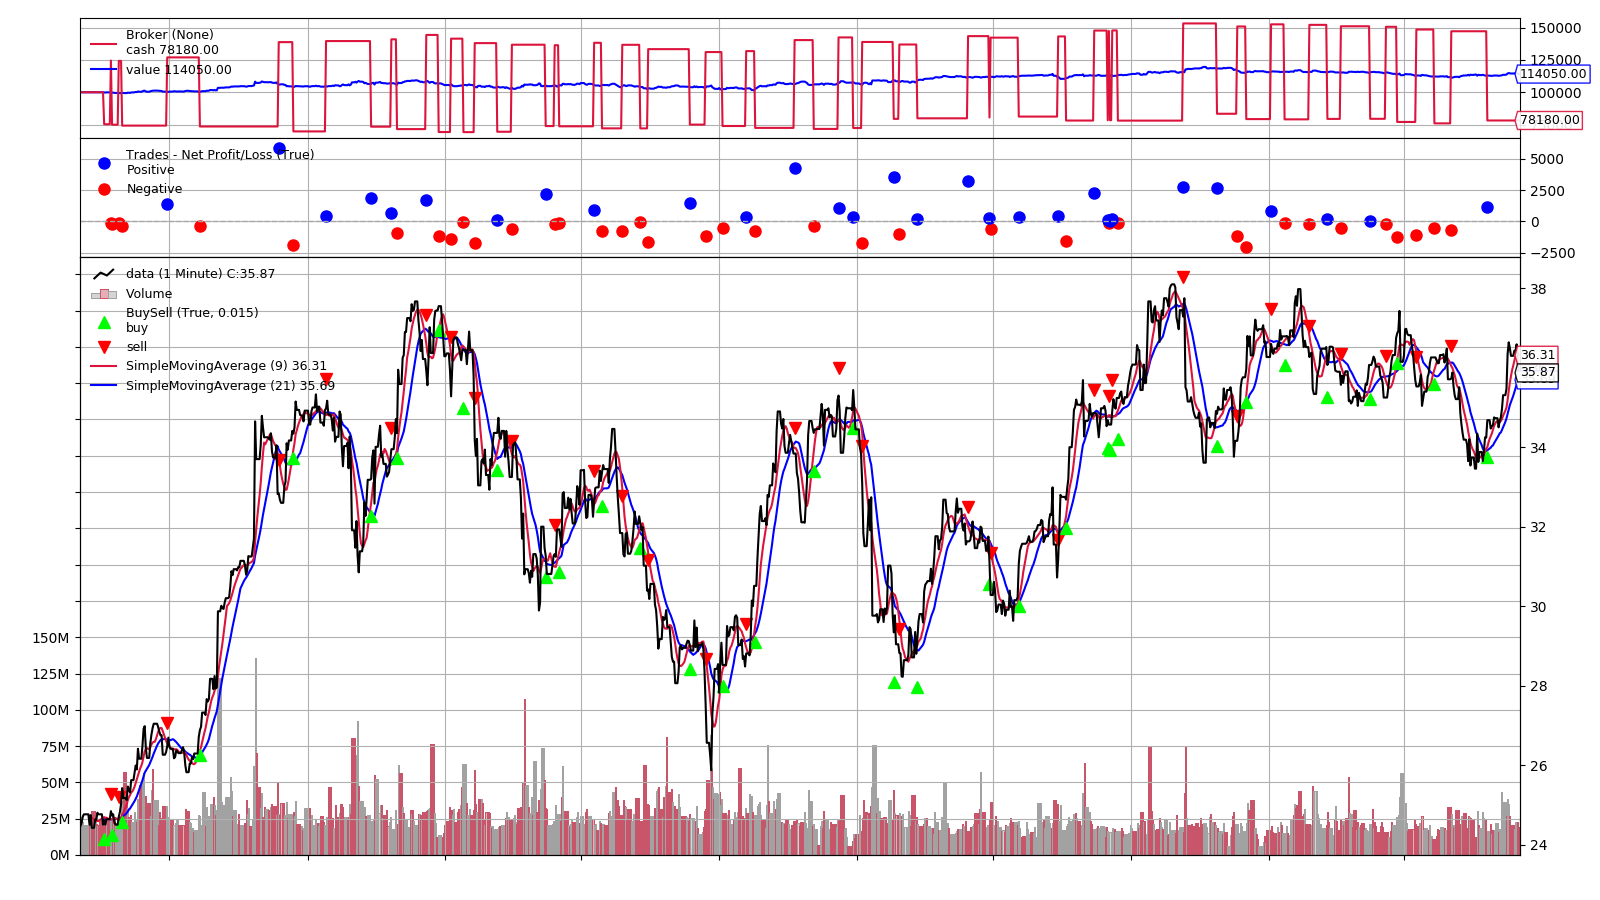

In [20]:
#Get Algo Chart from S3
model_name=algo.model_data.replace('s3://'+sess.default_bucket()+'/','')
import boto3
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(sess.default_bucket())
my_bucket.download_file(model_name,'model.tar.gz')
!tar -xzf model.tar.gz
!rm model.tar.gz
from IPython.display import Image
Image(filename='chart.png') 